# パラメータの更新
ニューラルネットワークの学習の目的は、損失関数の値をできるだけ小さくするパラメータを見つけることである。このような問題を解くことを、**最適化(optimization)**と言う。しかし、今日のニューラルネットワークにおけるパラメータ空間は非常に複雑であり、最適な解は簡単には見つからない。前回まで学習してきた**確率的勾配降下法(stochastic gradient descent)(通称SGD)**は単純な方法であり、問題によってはSGDよりも効率的な方法がある。

## SGD
SGDは、以下の数式で表される。
<br>
$W ← W - \eta {\large \frac{\partial L}{\partial W}}$
<br>
ここでは、更新する重みパラメータを$W$、$W$に関する損失関数の勾配を${\large \frac{\partial L}{\partial W}}$、学習係数を$\eta$とする。式中の左矢印は、右辺の値で左辺を更新すると言うことを表す。これをSGDという名前のクラスで実装すると以下のようになる。

In [1]:
class SGD:
    def __init__(self, lr=0.01): #lrは学習係数
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

## SGDの欠点
SGDの欠点を考えるにあたって、次の関数の最小値を求めることを考える。
<br>
$f(x,y)={\large \frac{1}{20}}x^2+y^2$
<br>
この関数の最小値をSGDで探索した場合の経路をグラフに可視化すると、以下のようになる。

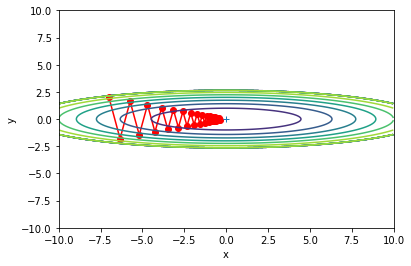

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizer = SGD(lr=0.95)
x_history = []
y_history = []
params['x'], params['y'] = init_pos[0], init_pos[1]
  
for i in range(30):
    x_history.append(params['x'])
    y_history.append(params['y'])
        
    grads['x'], grads['y'] = df(params['x'], params['y'])
    optimizer.update(params, grads)
    

x = np.arange(-10, 10, 0.01)
y = np.arange(-5, 5, 0.01)
    
X, Y = np.meshgrid(x, y) 
Z = f(X, Y)
    
# for simple contour line  
mask = Z > 7
Z[mask] = 0
    
# plot 
plt.plot(x_history, y_history, 'o-', color="red")
plt.contour(X, Y, Z)
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.plot(0, 0, '+')
plt.xlabel("x")
plt.ylabel("y")

plt.show()

このグラフからもわかるように、この場合SGDは遠回りをするようにパラメータを更新していく。つまり、SGDは関数の形状が等方的でないときには、非効率的な経路で探索を行うことになる。この欠点は、SGDにおける勾配は本来の最小値の方向と必ずしも等しくないというところから来ている。この欠点を改善する方法として、Momentam、AdaGrad、Adamという主に3つの手法がある。

## Momentum
モーメンタム（Momentum)とは、運動量という意味の言葉で、物理でよく使われる。Momentumという手法は、数式では次のように表される。
<br>
$v ← \alpha v - \eta {\large \frac{\partial L}{\partial W}} \\
W ← W + v$
<br>
ここでいう$v$は、物理で言う速度に対応する。1つ目の式では、物体が勾配方向に力を受け、その力によって物体の速度が加算されるという物理法則を表している。また、その式の$\alpha v$の項は、物体が何も力を受けない時に徐々に減速するための役割を成している。通常は$\alpha=0.9$あたりの値を代入する。この値は物理における摩擦や空気抵抗に対応する。これを実装すると以下のようになる。

In [7]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

## AdaGrad
ニューラルネットワークの学習では、学習係数が小さすぎると学習に時間がかかり、大きすぎても発散して正しい学習は行えない。このことに関する友好なテクニックとして、**学習係数の減衰(learning rate decay)**という方法がある。これは学習が進むにつれて係数を小さくするという学習である。学習係数を徐々に下げると言うことは、パラメータ全体の学習係数を一括して下げることに相当する。これを発展させたのが**AdaGrad**である。AdaGradは、一つ一つのパラメータに対してオーダーメイドの学習係数を定める手法である。AdaGradのAdaは適応的という意味のAdaptiveから来ている。これらの手法を数式で表すと次のようになる。
$h ← h + {\large \frac{\partial L}{\partial W}} \cdot {\large \frac{\partial L}{\partial W}} \\
W ← W - \eta {\large \frac{1}{\sqrt{h}}} {\large \frac{\partial L}{\partial W}}$
<br>
新たに登場した変数$h$は、これまで経験した勾配の値を2乗和として保持する。
<br>
これを実装すると以下のようになる。

In [4]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

ここでは、最後の計算の分母の部分で```self.h[key]```の平方根に1e-7を加算している。これは、```self.h[key]```の値が0だった場合に0除算を防ぐためである。多くのフレームワークではここの値もパラメータとして設定できる。

## Adam
AdamはMomentumとAdaGradを融合した、2015年に提案された新しい手法である。この手法を式で表すと以下のようになる。
<br>
$
v ← \beta_1 v + (1-\beta_1){\large \frac{\partial L}{\partial W}} \\
h ← \beta_2 h + (1-\beta_2){\large \frac{\partial L}{\partial W}} \cdot {\large \frac{\partial L}{\partial W}} \\
W ← W - \alpha {\large \frac{v}{\sqrt{h}}}
$
<br>
実装は下記。

In [5]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

## 更新手法の比較
ここまでに扱った4つの更新手法の更新過程をグラフに表すと、次のようになる。この問題ではAdaGradが最適に思えるが、それぞれの手法には長所と短所があるため、問題によって使い分けることが推奨される。

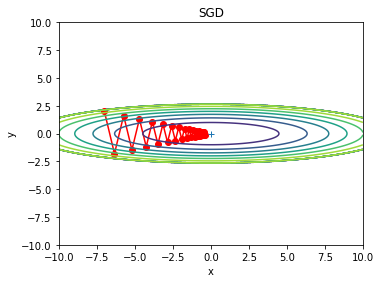

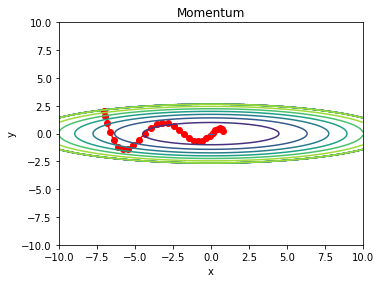

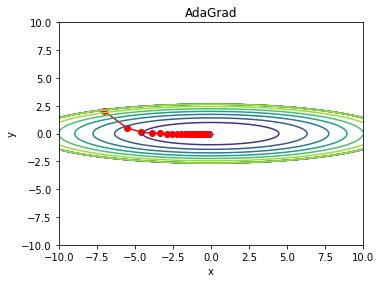

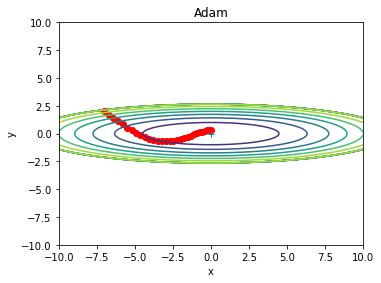

In [24]:
from collections import OrderedDict

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.figure(figsize=(12,9))
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

## MNISTデータセットによる更新手法の比較
手描き数字認識を対象に、4つの手法を比較してみる。実装は以下。

===========iteration:0===========
SGD:2.4809974313014846
Momentum:2.3837018873116227
AdaGrad:2.3776920133841175
Adam:2.1479385625298364
===========iteration:100===========
SGD:1.41846444787352
Momentum:0.4129146268868791
AdaGrad:0.2568558367733233
Adam:0.37979151067807004
===========iteration:200===========
SGD:0.6532485457242607
Momentum:0.21273160740632782
AdaGrad:0.10095010719513588
Adam:0.1570265172511324
===========iteration:300===========
SGD:0.43877747032825976
Momentum:0.11083463204508134
AdaGrad:0.03684859242491415
Adam:0.06813539788743564
===========iteration:400===========
SGD:0.3811886860859163
Momentum:0.1898203894300352
AdaGrad:0.08779032113041971
Adam:0.11443870418717918
===========iteration:500===========
SGD:0.3152345908939357
Momentum:0.06901421408833257
AdaGrad:0.027318079676015752
Adam:0.04735655659467336
===========iteration:600===========
SGD:0.24010270516486848
Momentum:0.0838927675522155
AdaGrad:0.02128881571013906
Adam:0.035537470028941226
===========iteration:

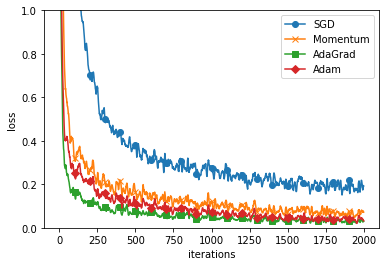

In [29]:
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

# 重みの初期値
ニューラルネットワークでは、重みの初期値をどのように設定するかで学習が成功するかどうかが変わってくる。ここまではガウス分布から生成されるランダムな数値を使用していたが、0などで単純に初期化しなかった理由としては、均一な値を設定してしまうと誤差逆伝播を行ったときに、全ての重みパラメータが均一に均一に更新されてしまうということがある。これでは、重みを持つ意味がなくなってしまう。

## 隠れ層のアクティベーション分布
隠れ層のアクティベーション（活性化関数後の出力データ）の分布を観察することで、重みの初期値による変化を観察する。ここでは5層のニューラルネットワークを用いて、各層のアクティベーション分布をヒストグラムで表示する。
<br>
- 重みの標準偏差が1のとき

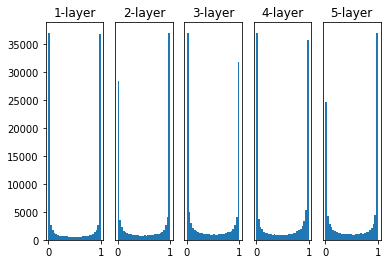

In [43]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 1

    a = np.dot(x, w)

    z = sigmoid(a)
    
    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():

    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

- 重みの標準偏差が0.01のとき

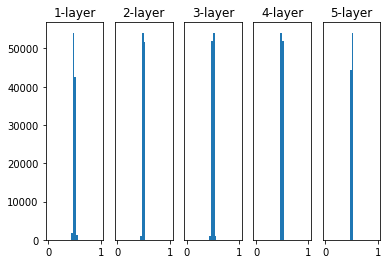

In [44]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 0.01

    a = np.dot(x, w)

    z = sigmoid(a)
    
    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

重みの標準偏差が1のときには、各層のアクティベーションが1たは0に偏ってしまった。このとき、どちらに偏ってもその微分の値は0となる。よって、勾配の値はどんどん小さくなっていき、勾配が消失してしまう。この問題を**勾配消失**といい、層を深く重ねていくディープラーニングにおいては深刻な問題となる。一方で、標準偏差が0.01であるとき、各層のアクティベーションは0.5付近に集中する分布となった。このとき、勾配消失の心配はない。しかし、複数のニューロンが似たような値を取っているというこは複数のニューロンがある必要性がなく、表現の制限という点で大きな問題がある。以上のことから、各層のアクティベーションの分布は適度な広がりを持つことが求められる。
<br>
この問題を回避する方法として、「Xavierの初期値」を使用する方法が挙げられる。これはXavier Glorotらの論文で提唱されたもので、前層のノードの数を$n$としたとき、${\large \frac{1}{\sqrt{n}}}$を標準偏差とした重みパラメータを用いるというものである。これを用いた実装が下記である。

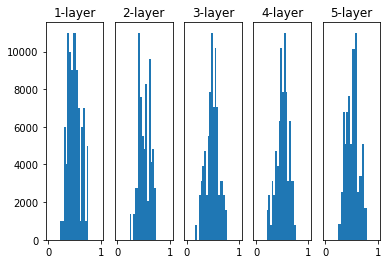

In [45]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)

    a = np.dot(x, w)

    z = sigmoid(a)
    
    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

ややいびつではあるが、広がりを持った分布であることが確認できる。

## ReLU関数の場合の重みの初期値
前述の「Xavierの初期値」は、活性化関数が線形関数である前提で導かれたものである。よって、sigmoid関数やtanh関数などの左右対称で中央付近が線形関数と近似できる関数が活性化関数である場合は適しているが、ReLU関数を用いる場合にはKaiming Heらが推奨する「Heの初期値」を用いることが推奨されている。これは前層のノードを$n$個としたとき、${\large\sqrt{\frac{2}{n}}}$を標準偏差とした分布を用いるものである。

## MNISTデータセットによる重みの初期値の比較
実際にMNISTデータセットの手書き文字認識を例に、重みの初期値が結果に与える影響を観察する。今回比較するのは、「標準偏差が0.01のガウス分布」、「Xavierの初期値」、「Heの初期値」の3つである。また、活性化関数にはReLU関数を用いる。

===========iteration:0===========
std=0.01:2.3025253163076123
Xavier:2.3040216120634165
He:2.36659042573655
===========iteration:100===========
std=0.01:2.3021793868911185
Xavier:2.2311155239995664
He:1.554971863157213
===========iteration:200===========
std=0.01:2.303234267941509
Xavier:2.117139458701249
He:0.7408041432962207
===========iteration:300===========
std=0.01:2.29980998613905
Xavier:1.6841614187177552
He:0.5087778482152264
===========iteration:400===========
std=0.01:2.303060321652733
Xavier:1.255208664761124
He:0.4477212178803874
===========iteration:500===========
std=0.01:2.2978767991933324
Xavier:0.8199325399727715
He:0.360541689250157
===========iteration:600===========
std=0.01:2.2996215948399747
Xavier:0.5797118268815826
He:0.2959673272625072
===========iteration:700===========
std=0.01:2.3061370931093386
Xavier:0.53515687396213
He:0.29954786246913634
===========iteration:800===========
std=0.01:2.3041908801679485
Xavier:0.49303682493130485
He:0.27204671754833754
===

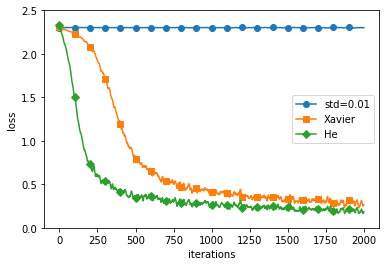

In [46]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

見て分かるとおり標準偏差が0.01のガウス分布を初期値として用いたとき、学習が全く進んでいない。これは順伝播のときに0に近い値が伝達されることにより、勾配消失が発生したためである。また、ReLU関数を活性化関数として使用しているため、「Xavierの初期値」より「Heの初期値」を用いたほうが学習の進みが早いことが分かる。

# Batch Normalization
Batch Normalization（以下Batch Norm）は、各層でアクティベーションの分布が適度な広がりを持つように強制的に調整を行う手法である。

## Batch Normalizationのアルゴリズム
この手法の利点として、次のようなことが挙げられる。
<br>
- 学習を速く進行させられる（学習係数を大きくできる）
- 初期値にそれほど依存しない（初期値に対して神経質にならなくていい）
- 過学習が抑制できる（Dropout（後述）などの必要性を減らせる）

この手法では、Batch Normalizationレイヤ（以下Batch Normレイヤ）という名前で、データ分布の正規化を行うレイヤをニューラルネットワークに挿入する。この手法では、ミニバッチごとにデータの分布が平均が0で分散が1になるように正規化を行う。数式で表すと以下のようになる。
<br>
$\displaystyle
\mu_B ← \frac{1}{m} \sum_{i=1}^m x_i \\
\displaystyle
\sigma_B^2 ← \frac{1}{m} \sum_{i=1}^m (x_i-\mu_B)^2 \\
\displaystyle
\hat{x}_i ← \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \varepsilon}}
$
<br>
ミニバッチとして入力されたデータ$B$の平均と分散を1つめと2つめの式で算出し、3つ目の式で正規化を行った。
<br>
さらに、Batch Normレイヤでは正規化したデータに対して固有のスケールとシフトで変換を行う。数式では次のように表される。
<br>
$y_i ← \gamma \hat{x}_i + \beta$
<br>
ここでは$\gammaと\beta$はパラメータであり、$\gamma = 1$、$\beta = 0$からスタートして、学習によって適した値に調整されていく。

## Batch Normalizationの評価
実際にBatch Normを使用した場合と使用していない場合で比較を行う。

============== 1/16 ==============
epoch:0 | 0.094 - 0.088
epoch:1 | 0.097 - 0.097
epoch:2 | 0.097 - 0.101
epoch:3 | 0.097 - 0.126
epoch:4 | 0.097 - 0.145
epoch:5 | 0.097 - 0.157
epoch:6 | 0.097 - 0.169
epoch:7 | 0.097 - 0.19
epoch:8 | 0.097 - 0.214
epoch:9 | 0.097 - 0.231
epoch:10 | 0.097 - 0.255
epoch:11 | 0.097 - 0.275
epoch:12 | 0.097 - 0.285
epoch:13 | 0.097 - 0.292
epoch:14 | 0.097 - 0.307
epoch:15 | 0.097 - 0.34
epoch:16 | 0.097 - 0.341
epoch:17 | 0.097 - 0.344
epoch:18 | 0.097 - 0.363
epoch:19 | 0.097 - 0.367


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 2/16 ==============
epoch:0 | 0.093 - 0.11
epoch:1 | 0.097 - 0.112
epoch:2 | 0.097 - 0.123
epoch:3 | 0.097 - 0.131
epoch:4 | 0.097 - 0.148
epoch:5 | 0.097 - 0.168
epoch:6 | 0.097 - 0.191
epoch:7 | 0.097 - 0.208
epoch:8 | 0.097 - 0.232
epoch:9 | 0.097 - 0.259
epoch:10 | 0.097 - 0.273
epoch:11 | 0.097 - 0.296
epoch:12 | 0.097 - 0.318
epoch:13 | 0.097 - 0.343
epoch:14 | 0.097 - 0.375
epoch:15 | 0.097 - 0.385
epoch:16 | 0.097 - 0.415
epoch:17 | 0.097 - 0.433


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.097 - 0.45
epoch:19 | 0.097 - 0.468
============== 3/16 ==============
epoch:0 | 0.079 - 0.091
epoch:1 | 0.406 - 0.11
epoch:2 | 0.563 - 0.146
epoch:3 | 0.611 - 0.19
epoch:4 | 0.692 - 0.223
epoch:5 | 0.758 - 0.256
epoch:6 | 0.816 - 0.301
epoch:7 | 0.835 - 0.342
epoch:8 | 0.868 - 0.375
epoch:9 | 0.893 - 0.407
epoch:10 | 0.911 - 0.428
epoch:11 | 0.92 - 0.445
epoch:12 | 0.946 - 0.477
epoch:13 | 0.954 - 0.494
epoch:14 | 0.964 - 0.518
epoch:15 | 0.967 - 0.54
epoch:16 | 0.976 - 0.553
epoch:17 | 0.984 - 0.584


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.987 - 0.6
epoch:19 | 0.989 - 0.62
============== 4/16 ==============
epoch:0 | 0.137 - 0.068
epoch:1 | 0.265 - 0.081
epoch:2 | 0.39 - 0.138
epoch:3 | 0.468 - 0.2
epoch:4 | 0.551 - 0.281
epoch:5 | 0.599 - 0.355
epoch:6 | 0.625 - 0.416
epoch:7 | 0.656 - 0.482
epoch:8 | 0.681 - 0.522
epoch:9 | 0.717 - 0.566
epoch:10 | 0.729 - 0.604
epoch:11 | 0.738 - 0.636
epoch:12 | 0.753 - 0.671
epoch:13 | 0.763 - 0.694
epoch:14 | 0.783 - 0.71
epoch:15 | 0.785 - 0.734
epoch:16 | 0.804 - 0.747
epoch:17 | 0.806 - 0.767
epoch:18 | 0.82 - 0.785


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.826 - 0.802
============== 5/16 ==============
epoch:0 | 0.112 - 0.106
epoch:1 | 0.125 - 0.138
epoch:2 | 0.127 - 0.311
epoch:3 | 0.13 - 0.472
epoch:4 | 0.132 - 0.528
epoch:5 | 0.143 - 0.595
epoch:6 | 0.153 - 0.645
epoch:7 | 0.167 - 0.674
epoch:8 | 0.175 - 0.696
epoch:9 | 0.178 - 0.722
epoch:10 | 0.19 - 0.744
epoch:11 | 0.191 - 0.772
epoch:12 | 0.203 - 0.794
epoch:13 | 0.221 - 0.806
epoch:14 | 0.228 - 0.817
epoch:15 | 0.239 - 0.831
epoch:16 | 0.244 - 0.848
epoch:17 | 0.258 - 0.849


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.268 - 0.859
epoch:19 | 0.274 - 0.873
============== 6/16 ==============
epoch:0 | 0.104 - 0.133
epoch:1 | 0.132 - 0.211
epoch:2 | 0.127 - 0.423
epoch:3 | 0.129 - 0.571
epoch:4 | 0.127 - 0.669
epoch:5 | 0.129 - 0.718
epoch:6 | 0.118 - 0.762
epoch:7 | 0.117 - 0.795
epoch:8 | 0.116 - 0.813
epoch:9 | 0.116 - 0.846
epoch:10 | 0.116 - 0.852
epoch:11 | 0.118 - 0.865
epoch:12 | 0.116 - 0.876
epoch:13 | 0.145 - 0.886
epoch:14 | 0.148 - 0.905
epoch:15 | 0.142 - 0.902
epoch:16 | 0.151 - 0.916
epoch:17 | 0.134 - 0.918
epoch:18 | 0.121 - 0.931


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.13 - 0.944
============== 7/16 ==============
epoch:0 | 0.094 - 0.076
epoch:1 | 0.117 - 0.198
epoch:2 | 0.117 - 0.546
epoch:3 | 0.117 - 0.718
epoch:4 | 0.117 - 0.804
epoch:5 | 0.117 - 0.835
epoch:6 | 0.117 - 0.857
epoch:7 | 0.117 - 0.87
epoch:8 | 0.117 - 0.887
epoch:9 | 0.117 - 0.906
epoch:10 | 0.117 - 0.921
epoch:11 | 0.117 - 0.941
epoch:12 | 0.117 - 0.955
epoch:13 | 0.117 - 0.962
epoch:14 | 0.117 - 0.965
epoch:15 | 0.117 - 0.972
epoch:16 | 0.117 - 0.974
epoch:17 | 0.117 - 0.98


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.117 - 0.98
epoch:19 | 0.117 - 0.989
============== 8/16 ==============
epoch:0 | 0.099 - 0.087
epoch:1 | 0.117 - 0.249
epoch:2 | 0.116 - 0.618
epoch:3 | 0.116 - 0.806
epoch:4 | 0.116 - 0.865
epoch:5 | 0.116 - 0.893
epoch:6 | 0.116 - 0.915
epoch:7 | 0.116 - 0.935
epoch:8 | 0.116 - 0.95
epoch:9 | 0.116 - 0.968
epoch:10 | 0.116 - 0.979
epoch:11 | 0.116 - 0.981
epoch:12 | 0.116 - 0.988
epoch:13 | 0.116 - 0.991
epoch:14 | 0.116 - 0.995
epoch:15 | 0.116 - 0.996
epoch:16 | 0.116 - 0.996
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.997


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.998
============== 9/16 ==============
epoch:0 | 0.099 - 0.105
epoch:1 | 0.117 - 0.434
epoch:2 | 0.116 - 0.728
epoch:3 | 0.116 - 0.787
epoch:4 | 0.116 - 0.832
epoch:5 | 0.117 - 0.868
epoch:6 | 0.116 - 0.932
epoch:7 | 0.117 - 0.97
epoch:8 | 0.117 - 0.988
epoch:9 | 0.116 - 0.988
epoch:10 | 0.116 - 0.995
epoch:11 | 0.116 - 0.998
epoch:12 | 0.116 - 0.998
epoch:13 | 0.116 - 0.999
epoch:14 | 0.116 - 1.0
epoch:15 | 0.116 - 1.0
epoch:16 | 0.116 - 1.0
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 1.0
============== 10/16 ==============
epoch:0 | 0.117 - 0.111
epoch:1 | 0.116 - 0.484
epoch:2 | 0.116 - 0.71
epoch:3 | 0.116 - 0.761
epoch:4 | 0.116 - 0.884
epoch:5 | 0.117 - 0.852
epoch:6 | 0.117 - 0.934
epoch:7 | 0.117 - 0.944
epoch:8 | 0.117 - 0.96
epoch:9 | 0.117 - 0.982
epoch:10 | 0.116 - 0.986
epoch:11 | 0.116 - 0.991
epoch:12 | 0.117 - 0.994
epoch:13 | 0.117 - 0.995
epoch:14 | 0.117 - 0.996
epoch:15 | 0.117 - 0.983
epoch:16 | 0.117 - 0.995
epoch:17 | 0.117 - 0.996


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.117 - 0.998
epoch:19 | 0.117 - 0.998
============== 11/16 ==============
epoch:0 | 0.116 - 0.157
epoch:1 | 0.116 - 0.702
epoch:2 | 0.116 - 0.761
epoch:3 | 0.116 - 0.771
epoch:4 | 0.116 - 0.82
epoch:5 | 0.116 - 0.846
epoch:6 | 0.116 - 0.855
epoch:7 | 0.116 - 0.885
epoch:8 | 0.116 - 0.886
epoch:9 | 0.116 - 0.892
epoch:10 | 0.116 - 0.954
epoch:11 | 0.116 - 0.976
epoch:12 | 0.116 - 0.976
epoch:13 | 0.116 - 0.969
epoch:14 | 0.116 - 0.982
epoch:15 | 0.116 - 0.988
epoch:16 | 0.116 - 0.729
epoch:17 | 0.116 - 0.953
epoch:18 | 0.116 - 0.968


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.99
============== 12/16 ==============
epoch:0 | 0.092 - 0.192
epoch:1 | 0.093 - 0.495
epoch:2 | 0.117 - 0.487
epoch:3 | 0.117 - 0.657
epoch:4 | 0.117 - 0.674
epoch:5 | 0.117 - 0.725
epoch:6 | 0.117 - 0.754
epoch:7 | 0.117 - 0.777
epoch:8 | 0.117 - 0.784
epoch:9 | 0.117 - 0.768
epoch:10 | 0.117 - 0.785
epoch:11 | 0.117 - 0.797
epoch:12 | 0.117 - 0.79
epoch:13 | 0.117 - 0.788
epoch:14 | 0.116 - 0.778
epoch:15 | 0.116 - 0.79
epoch:16 | 0.117 - 0.781
epoch:17 | 0.117 - 0.745


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.117 - 0.715
epoch:19 | 0.116 - 0.738
============== 13/16 ==============
epoch:0 | 0.116 - 0.097
epoch:1 | 0.116 - 0.381
epoch:2 | 0.116 - 0.468
epoch:3 | 0.117 - 0.549
epoch:4 | 0.117 - 0.553
epoch:5 | 0.117 - 0.576
epoch:6 | 0.117 - 0.607
epoch:7 | 0.117 - 0.627
epoch:8 | 0.117 - 0.53
epoch:9 | 0.117 - 0.528
epoch:10 | 0.117 - 0.619
epoch:11 | 0.117 - 0.619
epoch:12 | 0.117 - 0.623
epoch:13 | 0.116 - 0.618
epoch:14 | 0.116 - 0.626
epoch:15 | 0.116 - 0.703
epoch:16 | 0.116 - 0.667
epoch:17 | 0.116 - 0.699
epoch:18 | 0.116 - 0.7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.687
============== 14/16 ==============
epoch:0 | 0.117 - 0.208
epoch:1 | 0.117 - 0.299
epoch:2 | 0.117 - 0.315
epoch:3 | 0.117 - 0.31
epoch:4 | 0.117 - 0.325
epoch:5 | 0.117 - 0.327
epoch:6 | 0.117 - 0.381
epoch:7 | 0.117 - 0.393
epoch:8 | 0.117 - 0.396
epoch:9 | 0.117 - 0.337
epoch:10 | 0.117 - 0.417
epoch:11 | 0.117 - 0.408
epoch:12 | 0.117 - 0.404
epoch:13 | 0.117 - 0.414
epoch:14 | 0.117 - 0.477
epoch:15 | 0.117 - 0.377
epoch:16 | 0.117 - 0.509
epoch:17 | 0.117 - 0.517
epoch:18 | 0.117 - 0.487


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.518
============== 15/16 ==============
epoch:0 | 0.094 - 0.097
epoch:1 | 0.116 - 0.372
epoch:2 | 0.116 - 0.409
epoch:3 | 0.116 - 0.409
epoch:4 | 0.117 - 0.41
epoch:5 | 0.116 - 0.498
epoch:6 | 0.116 - 0.51
epoch:7 | 0.116 - 0.475
epoch:8 | 0.116 - 0.513
epoch:9 | 0.116 - 0.508
epoch:10 | 0.116 - 0.515
epoch:11 | 0.116 - 0.523
epoch:12 | 0.116 - 0.531
epoch:13 | 0.116 - 0.526
epoch:14 | 0.116 - 0.53
epoch:15 | 0.117 - 0.527
epoch:16 | 0.117 - 0.531
epoch:17 | 0.117 - 0.531


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.117 - 0.521
epoch:19 | 0.117 - 0.522
============== 16/16 ==============
epoch:0 | 0.087 - 0.162
epoch:1 | 0.116 - 0.219
epoch:2 | 0.116 - 0.318
epoch:3 | 0.116 - 0.267
epoch:4 | 0.116 - 0.378
epoch:5 | 0.116 - 0.394
epoch:6 | 0.116 - 0.402
epoch:7 | 0.116 - 0.383
epoch:8 | 0.116 - 0.351
epoch:9 | 0.116 - 0.372
epoch:10 | 0.116 - 0.373
epoch:11 | 0.116 - 0.334
epoch:12 | 0.116 - 0.334
epoch:13 | 0.116 - 0.328
epoch:14 | 0.116 - 0.478
epoch:15 | 0.116 - 0.407
epoch:16 | 0.116 - 0.507
epoch:17 | 0.116 - 0.514
epoch:18 | 0.116 - 0.516
epoch:19 | 0.116 - 0.512


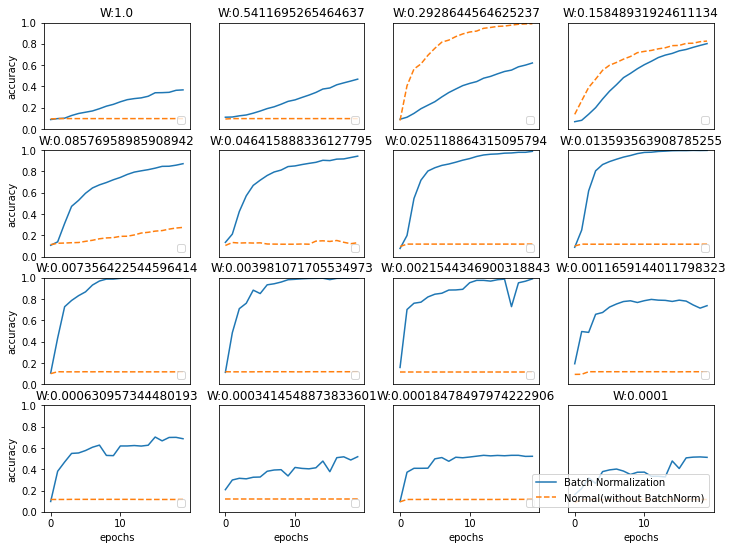

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)
plt.figure(figsize=(12,9))

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

Batch Normを使用した方が学習が速く進んでいることが分かる。実際、ほとんどのケースでは使用した方が学習が速く進む。

# 正規化
機械学習では**過学習**（overfitting）が問題になることが多い。機械学習では過学習を防ぎ汎化性能を高めることが肝要である。

## 過学習
過学習が起きる原因には主に次の2つがある。
- パラメータを大量に持ち、表現力の高いモデルであること
- 訓練データが少ないこと

この2つの条件をもとに、わざと過学習を起こしてみる。

epoch:0, train acc:0.10666666666666667, test acc:0.1028
epoch:1, train acc:0.12333333333333334, test acc:0.1087
epoch:2, train acc:0.14333333333333334, test acc:0.1223
epoch:3, train acc:0.18333333333333332, test acc:0.1419
epoch:4, train acc:0.24333333333333335, test acc:0.1776
epoch:5, train acc:0.2833333333333333, test acc:0.2084
epoch:6, train acc:0.30333333333333334, test acc:0.2351
epoch:7, train acc:0.35333333333333333, test acc:0.2634
epoch:8, train acc:0.38666666666666666, test acc:0.2806
epoch:9, train acc:0.42, test acc:0.3067
epoch:10, train acc:0.44333333333333336, test acc:0.3297
epoch:11, train acc:0.4633333333333333, test acc:0.3439
epoch:12, train acc:0.4633333333333333, test acc:0.358
epoch:13, train acc:0.48333333333333334, test acc:0.3652
epoch:14, train acc:0.4866666666666667, test acc:0.3712
epoch:15, train acc:0.5366666666666666, test acc:0.3911
epoch:16, train acc:0.5366666666666666, test acc:0.3877
epoch:17, train acc:0.5966666666666667, test acc:0.4228
epoch:1

epoch:172, train acc:1.0, test acc:0.7621
epoch:173, train acc:1.0, test acc:0.7608
epoch:174, train acc:1.0, test acc:0.7626
epoch:175, train acc:1.0, test acc:0.7618
epoch:176, train acc:1.0, test acc:0.7618
epoch:177, train acc:1.0, test acc:0.763
epoch:178, train acc:1.0, test acc:0.7608
epoch:179, train acc:1.0, test acc:0.7633
epoch:180, train acc:1.0, test acc:0.7648
epoch:181, train acc:1.0, test acc:0.7633
epoch:182, train acc:1.0, test acc:0.7638
epoch:183, train acc:1.0, test acc:0.7644
epoch:184, train acc:1.0, test acc:0.7658
epoch:185, train acc:1.0, test acc:0.7646
epoch:186, train acc:1.0, test acc:0.7648
epoch:187, train acc:1.0, test acc:0.7654
epoch:188, train acc:1.0, test acc:0.7646
epoch:189, train acc:1.0, test acc:0.7635
epoch:190, train acc:1.0, test acc:0.7649
epoch:191, train acc:1.0, test acc:0.7644
epoch:192, train acc:1.0, test acc:0.7657
epoch:193, train acc:1.0, test acc:0.7657
epoch:194, train acc:1.0, test acc:0.7658
epoch:195, train acc:1.0, test acc:

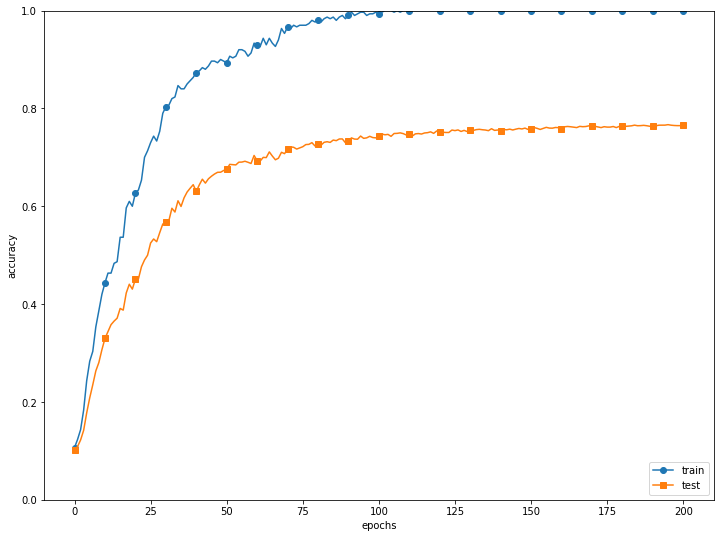

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
weight_decay_lambda = 0 # weight decayを使用しない場合
#weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

このように、訓練データについては最終的にほぼ100%の認識精度で出力するが、テストデータに対する出力はそこから大きく離れていることが分かる。

## Weight decay
過学習抑制のために用いられる手法として、**Weight decay**（荷重減衰）というものがある。これは学習の過程で大きな重みを持つことにペナルティを課すことでモデルの表現力を抑制して過学習を抑える方法である。このとき、具体的なペナルティとしては重みのL2ノルムを損失関数に加算する。（重みが$W$であるとして、$W$のL2ノルムである$\displaystyle \frac{1}{2} \lambda W^2$を損失関数に加算する。）$\lambda = 0.1$としてWeight decayを適応した実装が以下である。

epoch:0, train acc:0.1, test acc:0.1073
epoch:1, train acc:0.14, test acc:0.123
epoch:2, train acc:0.15, test acc:0.1396
epoch:3, train acc:0.17, test acc:0.1573
epoch:4, train acc:0.19666666666666666, test acc:0.1676
epoch:5, train acc:0.19, test acc:0.1735
epoch:6, train acc:0.21333333333333335, test acc:0.1976
epoch:7, train acc:0.22666666666666666, test acc:0.201
epoch:8, train acc:0.24333333333333335, test acc:0.2291
epoch:9, train acc:0.28, test acc:0.245
epoch:10, train acc:0.29333333333333333, test acc:0.2444
epoch:11, train acc:0.3, test acc:0.2436
epoch:12, train acc:0.35, test acc:0.2785
epoch:13, train acc:0.38666666666666666, test acc:0.3103
epoch:14, train acc:0.4033333333333333, test acc:0.313
epoch:15, train acc:0.41, test acc:0.3156
epoch:16, train acc:0.4033333333333333, test acc:0.3198
epoch:17, train acc:0.45666666666666667, test acc:0.3604
epoch:18, train acc:0.45666666666666667, test acc:0.3573
epoch:19, train acc:0.49666666666666665, test acc:0.3754
epoch:20, tra

epoch:156, train acc:0.9033333333333333, test acc:0.7209
epoch:157, train acc:0.8933333333333333, test acc:0.7235
epoch:158, train acc:0.9, test acc:0.7195
epoch:159, train acc:0.8966666666666666, test acc:0.7295
epoch:160, train acc:0.9033333333333333, test acc:0.7232
epoch:161, train acc:0.9066666666666666, test acc:0.7292
epoch:162, train acc:0.8933333333333333, test acc:0.7287
epoch:163, train acc:0.8966666666666666, test acc:0.7318
epoch:164, train acc:0.8866666666666667, test acc:0.726
epoch:165, train acc:0.9033333333333333, test acc:0.7347
epoch:166, train acc:0.9033333333333333, test acc:0.7299
epoch:167, train acc:0.8966666666666666, test acc:0.7158
epoch:168, train acc:0.9066666666666666, test acc:0.7232
epoch:169, train acc:0.9066666666666666, test acc:0.7378
epoch:170, train acc:0.92, test acc:0.7238
epoch:171, train acc:0.8966666666666666, test acc:0.7106
epoch:172, train acc:0.8966666666666666, test acc:0.7087
epoch:173, train acc:0.8833333333333333, test acc:0.7188
epoc

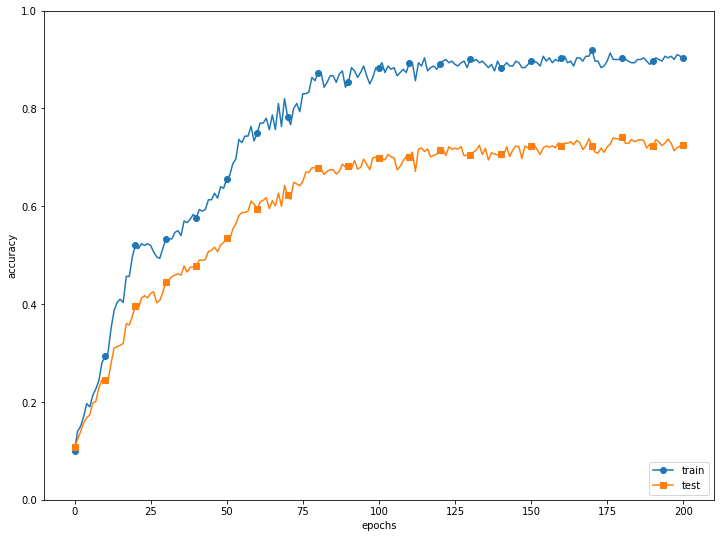

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

このとき、訓練データにおける認識精度は低下したが、テストデータにおける認識精度との差は縮まっていることから、同じネットワークと同じデータ数でも過学習を抑制できたことが分かる。

## Dropout
DropoutはWeight decayで対応できない複雑なモデルによく用いられる過学習を抑制する手法。この手法ではニューロンをランダムに消去しながら学習を行う。訓練時にはランダムにニューロンを選択して消去するが、テスト時は全てのニューロンに信号を伝達し、訓練時に消去した割合を乗算して出力する。この手法を適応した実装が下記。（Dropoutする割合は15％）

train loss:2.307565024848439
=== epoch:1, train acc:0.06333333333333334, test acc:0.07 ===
train loss:2.2971372618486128
train loss:2.3083629698165704
train loss:2.309916814580356
=== epoch:2, train acc:0.06, test acc:0.0718 ===
train loss:2.3077865355972063
train loss:2.3121530179479364
train loss:2.318451762447182
=== epoch:3, train acc:0.06333333333333334, test acc:0.0736 ===
train loss:2.303031253835706
train loss:2.3156336949328233
train loss:2.296593548577902
=== epoch:4, train acc:0.06, test acc:0.077 ===
train loss:2.303115706723033
train loss:2.300815055183923
train loss:2.306668884148045
=== epoch:5, train acc:0.06666666666666667, test acc:0.0779 ===
train loss:2.296431736860914
train loss:2.303707478896403
train loss:2.291275988762692
=== epoch:6, train acc:0.07, test acc:0.0792 ===
train loss:2.300113065506432
train loss:2.297268586809685
train loss:2.301041902737919
=== epoch:7, train acc:0.06333333333333334, test acc:0.0855 ===
train loss:2.2922534740093816
train loss:2.2

=== epoch:57, train acc:0.16666666666666666, test acc:0.1582 ===
train loss:2.241929423856655
train loss:2.2613697910431965
train loss:2.2302020149579684
=== epoch:58, train acc:0.17333333333333334, test acc:0.1659 ===
train loss:2.2218672741127885
train loss:2.261987648238538
train loss:2.242625604864952
=== epoch:59, train acc:0.17333333333333334, test acc:0.1668 ===
train loss:2.223928811836343
train loss:2.246418523814305
train loss:2.23973500998077
=== epoch:60, train acc:0.17666666666666667, test acc:0.1673 ===
train loss:2.2384425993001655
train loss:2.2181561252618724
train loss:2.2390187667321353
=== epoch:61, train acc:0.17666666666666667, test acc:0.1676 ===
train loss:2.217498099671742
train loss:2.2509212990398533
train loss:2.2170813404284875
=== epoch:62, train acc:0.17666666666666667, test acc:0.1684 ===
train loss:2.229911604550239
train loss:2.254086917781042
train loss:2.223438352201195
=== epoch:63, train acc:0.17666666666666667, test acc:0.1651 ===
train loss:2.235

=== epoch:113, train acc:0.33666666666666667, test acc:0.2818 ===
train loss:2.1050662964491034
train loss:2.138458124124818
train loss:2.1355232180456607
=== epoch:114, train acc:0.33666666666666667, test acc:0.278 ===
train loss:2.134600721505492
train loss:2.1517835836219743
train loss:2.176981027067751
=== epoch:115, train acc:0.3433333333333333, test acc:0.2866 ===
train loss:2.1762072075980163
train loss:2.1317200229082074
train loss:2.1342415830647936
=== epoch:116, train acc:0.3466666666666667, test acc:0.2874 ===
train loss:2.196871520685936
train loss:2.085201610175714
train loss:2.150505540920003
=== epoch:117, train acc:0.3433333333333333, test acc:0.2859 ===
train loss:2.080487598420783
train loss:2.1687754020224346
train loss:2.112507803398944
=== epoch:118, train acc:0.34, test acc:0.2844 ===
train loss:2.1555793658116973
train loss:2.127011767338928
train loss:2.1860544140805347
=== epoch:119, train acc:0.3566666666666667, test acc:0.2877 ===
train loss:2.13934242122652

=== epoch:169, train acc:0.5866666666666667, test acc:0.4266 ===
train loss:1.9120868347060007
train loss:2.0236110354398904
train loss:1.9335231308280099
=== epoch:170, train acc:0.5966666666666667, test acc:0.4276 ===
train loss:1.9125697882657005
train loss:1.8924161973681877
train loss:1.9298843065326583
=== epoch:171, train acc:0.5866666666666667, test acc:0.4271 ===
train loss:1.9069255872136373
train loss:1.938916245420174
train loss:1.835867095108262
=== epoch:172, train acc:0.58, test acc:0.4264 ===
train loss:1.953417821287002
train loss:1.923773960703263
train loss:1.9416489613168608
=== epoch:173, train acc:0.5933333333333334, test acc:0.4326 ===
train loss:1.8834842419633053
train loss:1.995701089386225
train loss:1.8689486047040738
=== epoch:174, train acc:0.59, test acc:0.4342 ===
train loss:1.9488133529005132
train loss:1.8496182209306233
train loss:1.870241360406152
=== epoch:175, train acc:0.5833333333333334, test acc:0.4289 ===
train loss:1.9531868717964338
train los

=== epoch:225, train acc:0.5833333333333334, test acc:0.5056 ===
train loss:1.5964843655563659
train loss:1.6152234146448743
train loss:1.6018795639547958
=== epoch:226, train acc:0.5833333333333334, test acc:0.5065 ===
train loss:1.5210640741702923
train loss:1.5513438134300415
train loss:1.460493783541418
=== epoch:227, train acc:0.5833333333333334, test acc:0.5049 ===
train loss:1.5673164516237552
train loss:1.5479881536218023
train loss:1.5942301256950975
=== epoch:228, train acc:0.5833333333333334, test acc:0.5066 ===
train loss:1.5923361642598926
train loss:1.43519004526715
train loss:1.6159500810191012
=== epoch:229, train acc:0.5933333333333334, test acc:0.5097 ===
train loss:1.6554607583770706
train loss:1.5190385451351498
train loss:1.6049477513289756
=== epoch:230, train acc:0.5733333333333334, test acc:0.507 ===
train loss:1.4357428284132954
train loss:1.6542933214964748
train loss:1.482587384658414
=== epoch:231, train acc:0.5833333333333334, test acc:0.5097 ===
train loss

=== epoch:281, train acc:0.6833333333333333, test acc:0.5676 ===
train loss:1.1222681699388943
train loss:1.1434553245693764
train loss:1.1896981803078222
=== epoch:282, train acc:0.6766666666666666, test acc:0.5714 ===
train loss:1.2265437417677485
train loss:1.1355041149407974
train loss:1.1781859102334447
=== epoch:283, train acc:0.6833333333333333, test acc:0.5716 ===
train loss:1.1176822319165367
train loss:1.1479264611140967
train loss:1.2006876961630595
=== epoch:284, train acc:0.69, test acc:0.5778 ===
train loss:1.1475605518621093
train loss:1.1302424146579453
train loss:1.1861672378371033
=== epoch:285, train acc:0.7, test acc:0.5801 ===
train loss:1.1457691870798223
train loss:1.132639486680068
train loss:1.2944671333526836
=== epoch:286, train acc:0.6966666666666667, test acc:0.5766 ===
train loss:1.201982462540827
train loss:1.2435942516613219
train loss:1.139361352291491
=== epoch:287, train acc:0.7033333333333334, test acc:0.5796 ===
train loss:1.148822618696717
train lo

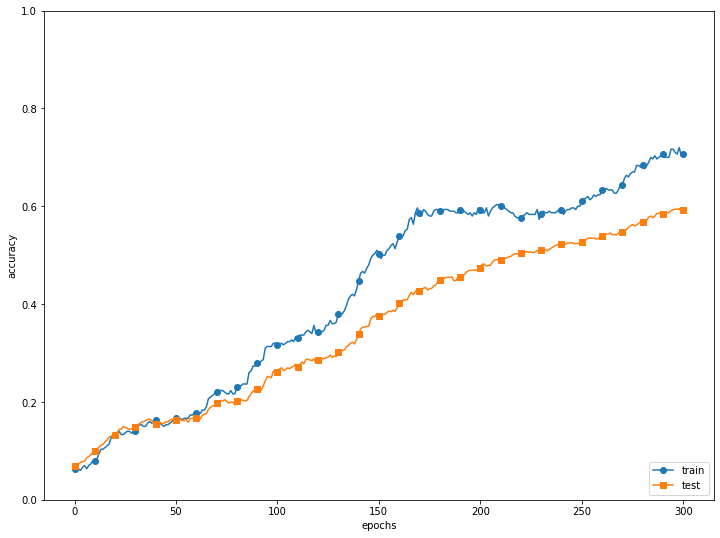

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

過学習が抑制できている。

# ハイパーパラメータの検証
ニューラルネットワークでは、ハイパーパラメータを適切に設定することが重要である。

## 検証データ
ハイパーパラメータは、テストデータによって性能を評価してはいけない。これはテストデータによってパラメータの調整を行うことで汎化性能が下がってしまうからである。そのため、ハイパーパラメータの調整用には一般に**検証データ**を使用する。

## ハイパーパラメータの最適化
ハイパーパラメータの最適化は以下のように行う。

1. ハイパーパラメータの範囲を大まかに設定する（10のべき乗くらいのスケールでおおまかに）
1. 設定した範囲からランダムにサンプリングする
1. サンプリングされた値で学習を行い、検証データで検証を行う（ただしエポック数は小さくする）
1. 2と3を何回か（100回など）繰り返し、その認識精度からパラメータの範囲を絞る。

上記の手順を繰り返し、ある程度まで絞り込んだところで値を1つ選び出す。

## ハイパーパラメータ最適化の実装
MNISTデータセットの文字認識を例として、ハイパーパラメータ最適化の実装を行う。ここでは学習係数とWeight decayの強さを決定する係数（以下Weight decay係数）を探索の対象とする。

val acc:0.13 | lr:4.697847510469589e-06, weight decay:1.896393729816627e-05
val acc:0.13 | lr:0.0001682212243044825, weight decay:1.1308385231678662e-06
val acc:0.09 | lr:8.125092676310253e-06, weight decay:1.2449631834119436e-08
val acc:0.1 | lr:6.399781864696607e-05, weight decay:1.2183871126621292e-07
val acc:0.11 | lr:3.7549354934747286e-05, weight decay:5.068622333504647e-07
val acc:0.08 | lr:0.0005064811291449513, weight decay:3.6203390163078627e-07
val acc:0.07 | lr:6.275516536575076e-06, weight decay:1.430035221772458e-05
val acc:0.1 | lr:4.224475001234429e-06, weight decay:1.0923698112172312e-07
val acc:0.06 | lr:9.79516770286426e-06, weight decay:5.025744931687076e-05
val acc:0.07 | lr:6.957295597494161e-05, weight decay:1.8237353857779808e-06
val acc:0.11 | lr:5.030099085067333e-05, weight decay:5.127299381357604e-08
val acc:0.06 | lr:0.00021622579477444874, weight decay:2.469457302714712e-06
val acc:0.11 | lr:4.45075689677377e-05, weight decay:6.710250163353993e-08
val acc:

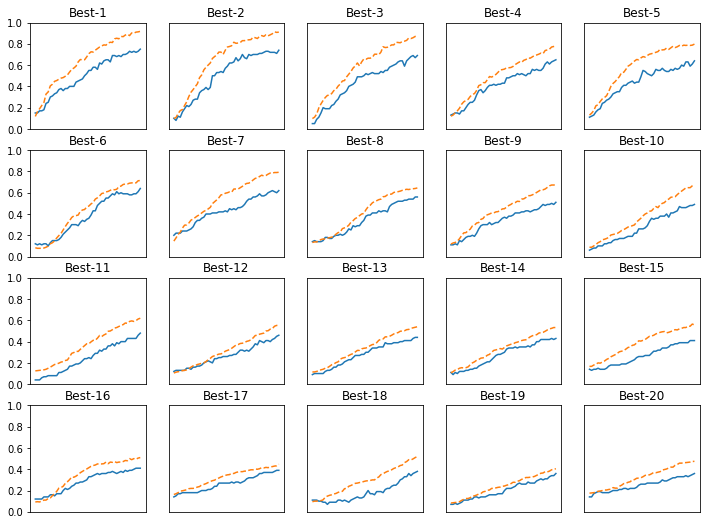

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()


これを見ると、Best-5あたりまでは学習が順調であるように見える。このときのハイパーパラメータの値は出力より、
<br>
>Best-1(val acc:0.75) | lr:0.00993339511507285, weight decay:7.09269984022727e-07<br>
>Best-2(val acc:0.74) | lr:0.007662707936348726, weight decay:3.2579716406035555e-06<br>
>Best-3(val acc:0.69) | lr:0.0077801907685511075, weight decay:1.7215171211577244e-07<br>
>Best-4(val acc:0.65) | lr:0.004525072568482032, weight decay:5.028283266813143e-05<br>
>Best-5(val acc:0.64) | lr:0.004459770693015388, weight decay:1.1002019840966573e-08

よって学習係数は0.01～0.001、Weight decay係数は$10^{-9}～10^{-6}$あたりが適していると考えられる。